In [1]:
from pyLIQTR.ProblemInstances.getInstance   import *
from pyLIQTR.BlockEncodings.getEncoding     import *
from pyLIQTR.utils.circuit_decomposition    import circuit_decompose_multi
from pyLIQTR.utils.resource_analysis        import estimate_resources
from pyLIQTR.qubitization.qubitized_gates   import QubitizedWalkOperator
from pyLIQTR.clam.lattice_definitions       import CubicLattice, SquareLattice, TriangularLattice
from pyLIQTR.utils.printing                 import openqasm
from pyLIQTR.scheduler.scheduler            import schedule_circuit
from pyLIQTR.scheduler.scheduler            import decomposition_protocol 
from pyLIQTR.scheduler.scheduler_utils      import plot_results

import cirq
import qualtran as qt
import matplotlib.pyplot as plt
from pyLIQTR.scheduler.scheduler_utils import architecture, state_factory
import pyLIQTR.scheduler.sets as sets


### Building circuit for scheduling

In [2]:

N=2

J_x = J_y = -0.5;                J_z = -1.0
h_x = 1.0;      h_y = 0.0;       h_z = 0.5

model  =  getInstance( "Heisenberg", 
                       shape=(N,N), 
                       J=(J_x,J_y,J_z), 
                       h=(h_x,h_y,h_z), 
                       cell=SquareLattice )

block_encoding    =  getEncoding(VALID_ENCODINGS.PauliLCU)(model)
circuit = block_encoding.circuit


In [3]:
resources = estimate_resources(circuit, circuit_precision=1e-3)
print(resources)

{'LogicalQubits': 9, 'T': 3320, 'Clifford': 6971}


---
#### LIQTR Like 👍 : Circuit Scheduling
---

Circuits can be 'scheduled' using the `pyLIQTR.scheduler.scheduler.schedule_circuit` function. This will provide circuit runtime, realistic qubit counts, T-depth, and more!

(NOTE: If any operator's decomposition method returns `None` or `NotImplemented`, the scheduler will refer to the operator's `t_complexity` method for gate counts and execution time, but will not be able to fully parallelize the operator. If the operator does not have a decomposition method or a `t_complexity` method defined, the operator will be skipped each time it occurs in the circuit. In this event, scheduling results will not be accurate to the true circuit.)

`schedule_circuit` takes a number of optional arguments depending on desired outputs. They are:
* `architecture_config`: default `None`. An `architecture` class object specifying gate times and state factory parameters. See 'Setting Gate Times and Magic State Factories' below for details.

* `full_profile`: default `False`. If set to `True`, function output will include individual gate counts, T-widths, and parallelism distribution data. (NOTE: T-widths and parallelism data will only be available if `decomp_level` is set to `'Full'`.)

* `decomp_level`: default `0`. Levels of decomposition implemented before scheduling. If set to `0`, each operator will be decomposed to one/two-qubit gates only on its first occurance and cached for each future occurance. If set to `'Full'`, entire circuit will be decomposed to one/two-qubit gates before scheduling. 

    * NOTE: T-depth, qubit counts, and execution time will differ at different decomposition levels. In general, lower decomposition levels will trade circuit parallelism and low execution time for less qubit usage, whereas higher levels or full decomposition will maximize parallelism and decrease execution time while using more qubits. 

* `context`: default `None`. Defines qubit management context. We recommend not changing default settings unless required.

* `rotation_gate_precision`: default `5e-6`. Desired precision for circuit decomposition, namely breaking rotations into T-Gates.

* `decomposition_protocol`: default `decomposition_protocol.recursive`. Method of advanced decomposition to be used for complex operations, either `decomposition_protocol.recursive` or `decomposition_protocol.hierarchical`. See `advanced_decomposition_examples.ipynb` for further details.

* `qasm_output`: default `False`. If set to `True`, in addition to scheduling results, scheduler will print a qasm output of the scheduled circuit, including lines specifying start times of operations preceded by `#`.

* `display_op_cache`: default `False`. If set to `True`, in addition to scheduling results, scheduler will print each operator in its top-level cache along with that operator's stored results and how many times it occurred.

    * NOTE: Which operators appear in the cache will vary with different decomposition levels.

* `instance_name`: default `None`. If set (`str`), results dictionary will include an `Instance name` key. If `instance_name == None` while `json_output_filename != None`, `json_output_filename` will be used as the instance name for labelling purposes.

* `json_output_filename`: default `None`. If set (`str`), results dictionary will output to a JSON file named according to the input. Example output is available in this folder as `3x3_heisenberg_sched_output.json`.

If `decomp_level == 'Full'`, the full results profile will include `Active Qubit Distribution`, `T-widths`, `T-proportion`, and `Clifford/T ratios`:
* `Active Qubit Distribution`: how many qubits are active during an individual time-step, organized by number of occurances.

* `T-widths`: number of T-gates in an individual time-step, organized by number of occurances.

* `T-proportion`: proportion of T-gates to other gates in an individual time-step, organized by number of occurances.

* `Clifford/T ratio`: the number of Clifford gates followed by number of T-gates in each time-step, organized chronologically.

These results can be plotted as below for parallelism analysis.

Developer's Note: Unless your circuit is large to the point of not being decomposable in a reasonable amount of time, we recommend `decomp_level='Full'` for the most accurate results.

In [4]:
res = schedule_circuit(circuit, full_profile=True, decomp_level='Full', instance_name='3x3 Heisenberg', json_output_filename='3x3_heisenberg_sched_output')
for r in res:
    print(f"{r} : {res[r]}")

Total time for execution : 596500
Circuit T-depth : 2732
Number of qubits used : 13
Gate profile : {'T': 2760, 'H': 5418, 'S': 46, 'CX': 310, 'Toffoli': 0, 'CZ': 38, 'Pauli (X, Y, Z)': 146, 'Measurement/Reset': 60}
Active qubit distribution : {8: 2, 1: 167, 3: 88, 2: 175, 4: 47, 5: 33, 6: 7, 7: 2}
T-widths : {0: 382, 1: 117, 3: 3, 2: 19, 4: 1}
T-proportion : {0: 382, 1.0: 64, 0.5: 39, 0.33: 17, 0.67: 11, 0.75: 2, 0.29: 1, 0.25: 5, 0.2: 1}
Clifford/T ratios : {0: (0, 0), 1: (8, 0), 2: (0, 1), 3: (0, 3), 4: (0, 1), 5: (0, 1), 6: (1, 1), 7: (1, 0), 8: (0, 1), 9: (1, 0), 10: (1, 0), 11: (1, 0), 12: (0, 1), 13: (1, 0), 14: (1, 0), 15: (0, 1), 16: (1, 0), 17: (1, 0), 18: (1, 0), 19: (1, 0), 20: (1, 1), 21: (0, 1), 22: (0, 1), 23: (1, 0), 24: (0, 1), 25: (0, 1), 26: (1, 0), 27: (1, 0), 28: (0, 1), 29: (1, 0), 30: (1, 0), 31: (1, 0), 32: (1, 0), 33: (1, 0), 34: (1, 0), 35: (1, 0), 36: (1, 0), 37: (0, 1), 38: (1, 0), 39: (1, 0), 40: (0, 1), 41: (1, 0), 42: (1, 0), 43: (1, 0), 44: (0, 1), 45: (2

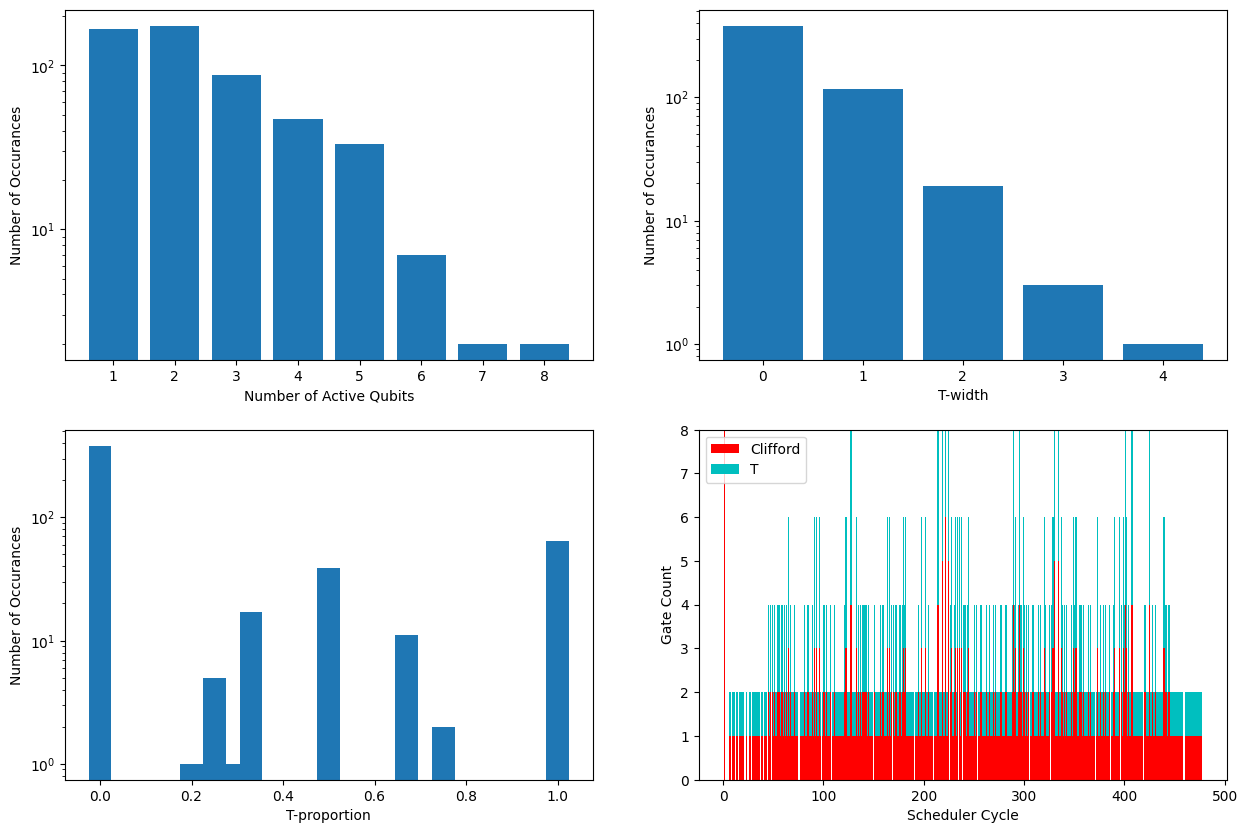

In [5]:
plot_results(res)


#### Setting Gate Times and Magic State Factories:
To specify how long a particular gate takes to operate or to model magic state factories, the user can build a configuration dictionary to be passed to the `architecture_config` argument of the `schedule_circuit` function.

##### Magic State Factory Configuration:
Each factory is implemented as an instance of the `state_factory` class. This object is initialized with 4 required arguments:
* `production_time`: the time it takes to produce a single state.
* `consumption_time`: the time it takes to consume a single state, once produced.
* `production_limit`: the capacity of the factory's 'state pool', i.e. how many produced states it can hold before halting production.
* `success_prob`: the probability (expressed as a `float`) of producing a successful state during a production run. For example, a factory which produces a successful state on every run would have `success_prob = 1.0`, and a factory which produces a successful state half of the time would have `success_prob = 0.5`.

If you are creating multiple factories for the same type of state, they do not have to have the same parameters, as seen below. The scheduler will account for all factories and choose one to produce a state when needed.

In [6]:
t_factory_1 = state_factory(production_time=4, consumption_time=1, production_limit=2, success_prob=0.5)

##### Gate Timing Dictionary
We can now decide which gates we want included in scheduler analysis and how long those gates take to execute. Using pre-built `sets`, we can specify each desired gate type in one of two ways. A gate which is not reliant on a magic state factory can simply be keyed to an integer representing the time to execute that gate type. A gate which does depend on a factory (or factories) is keyed to its respective factory, if there is only one, or a list of factories, if there are multiple.

Using this dictionary, we create an `architecture` object. In general, the only initializing argument for this object will be `user_input_timings`, to which we input the timing dictionary.

In the example below, we want to analyze the circuit in terms of T-gates, Clifford gates, and Miscellaneous gates*. Clifford and Miscellaneous gates are not factory-reliant, while T-gates are.

*Note that `sets.MISC` includes only Measurement and Qubit Reset "gates" and must be included in every timing dictionary.



In [7]:
my_timings = {sets.T: t_factory_1, sets.CLIFFORD: 1, sets.MISC: 0}
my_params = architecture(user_input_timings=my_timings)

























































Finally, we input the `architecture` object as the `architecture_config` argument of `schedule_circuit`, as below. The output of this function will have the same structure as any other `schedule_circuit` call, but the actual values will account for all the architecture specifications we've made. If JSON output is specified, all input architecture parameters will be included in that file.

In [8]:
schedule_circuit(circuit, architecture_config=my_params, decomp_level='Full')

{'Total time for execution': 20062,
 'Circuit T-depth': 2759,
 'Number of qubits used': 13,
 'Gate profile': {'T': 2760, 'Clifford': 5958, 'Measurement/Reset': 60}}

### QASM input/output:

In addition to a `cirq.Circuit`, you can input a qasm string (or list of qasm strings) to the `circuit` argument of `schedule_circuit`. You can also receive the scheduled circuit as a qasm output. 

* NOTE: a number of features will not be available when using qasm input, including the ability to specify `custom_gateset` or any decomposition features.  

In [9]:
circuit = ['h q[22]','h q[25]','h q[7]','t q[7]','cx q[18], q[7]','cx q[19], q[7]','cx q[7], q[18]','cx q[7], q[19]','tdg q[18]','tdg q[19]','t q[7]','cx q[7], q[18]', 'cx q[7], q[19]', 'h q[7]','s q[7]','h q[1]','t q[1]','cx q[7], q[1]','cx q[23], q[1]','cx q[1], q[7]', 'cx q[1], q[23]','tdg q[7]','tdg q[23]','t q[1]','cx q[1], q[7]','cx q[1], q[23]','h q[1]','s q[1]','h q[0]','t q[0]']

res = schedule_circuit(circuit, full_profile=True, qasm_output=True)
for r in res:
    print(f'{r}: {res[r]}')

#Operations finishing at 0: 
#Operations finishing at 100: 
h q[22]
h q[25]
h q[7]
h q[1]
h q[0]
#Operations finishing at 200: 
t q[7]
#Operations finishing at 300: 
t q[1]
t q[0]
#Operations finishing at 400: 
cx q[19], q[7]
cx q[18], q[7]
cx q[23], q[1]
#Operations finishing at 500: 
cx q[7], q[19]
cx q[7], q[18]
tdg q[19]
tdg q[18]
t q[7]
#Operations finishing at 700: 
cx q[7], q[19]
cx q[7], q[18]
#Operations finishing at 800: 
h q[7]
#Operations finishing at 900: 
s q[7]
#Operations finishing at 1100: 
cx q[7], q[1]
#Operations finishing at 1300: 
cx q[1], q[23]
cx q[1], q[7]
#Operations finishing at 1400: 
tdg q[23]
tdg q[7]
t q[1]
#Operations finishing at 1600: 
cx q[1], q[23]
cx q[1], q[7]
#Operations finishing at 1700: 
h q[1]
#Operations finishing at 1800: 
s q[1]
Total time for execution: 1800
Circuit T-depth: 4
Number of qubits used: 8
Gate profile: {'T': 9, 'H': 7, 'S': 2, 'CX': 12, 'Toffoli': 0, 'CZ': 0, 'Pauli (X, Y, Z)': 0, 'Measurement/Reset': 0, 'Other': 0, 'CY': 0, '